Authors
* Kush **Gupta**, kushg1121@gmail.com
* Sebestyén **Németh**, nemeth.sbn@gmail.com

In [ ]:
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

In [ ]:
!mkdir -p images
!wget -q https://people.math.sc.edu/Burkardt/data/tif/cameraman.tif -O images/cameraman.tif
!wget -q https://www.math.u-bordeaux.fr/~jaujol/code/Im1.png -O images/Im1.png
!wget -q http://www.math.u-bordeaux.fr/~jaujol/code/Im1_mask.png -O images/Im1_mask.png
!wget -q https://www.math.u-bordeaux.fr/~jaujol/code/Im2.png -O images/Im2.png
!wget -q https://www.math.u-bordeaux.fr/~jaujol/code/Im2_mask.png -O images/Im2_mask.png
!wget -q https://www.math.u-bordeaux.fr/~jaujol/code/Im3.png -O images/Im3.png
!wget -q https://www.math.u-bordeaux.fr/~jaujol/code/Im3_mask.png -O images/Im3_mask.png

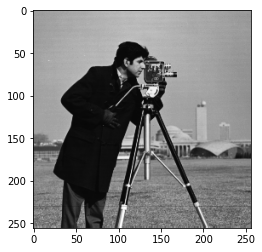

In [ ]:
Im_PIL = Image.open('images/cameraman.tif')
Im_data = np.array(Im_PIL)

bounds = {'vmin': 0, 'vmax': 255}

plt.imshow(Im_data, cmap='gray', **bounds)
plt.show()

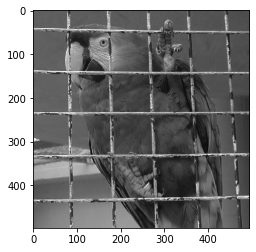

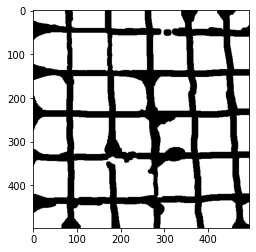

In [ ]:
Im_PIL = Image.open('images/Im1.png')
Im1 = np.array(Im_PIL).astype(np.float64)

Im_PIL = Image.open('images/Im1_mask.png')
Im1_mask = np.array(Im_PIL).astype(np.float64)

Im_PIL = Image.open('images/Im2.png')
Im2 = np.array(Im_PIL).astype(np.float64)

Im_PIL = Image.open('images/Im2_mask.png')
Im2_mask = np.array(Im_PIL).astype(np.float64)

Im_PIL = Image.open('images/Im3.png')
Im3 = np.array(Im_PIL).astype(np.float64)

Im_PIL = Image.open('images/Im3_mask.png')
Im3_mask = np.array(Im_PIL).astype(np.float64)

bounds = {'vmin': 0, 'vmax': 255}

plt.imshow(Im1, cmap='gray', **bounds)
plt.show()

plt.imshow(Im1_mask, cmap='gray', **bounds)
plt.show()

In [ ]:
def add_gaussian_noise(I, s):
  m, n = I.shape
  I_out = I + s * np.random.randn(m, n)
  return I_out

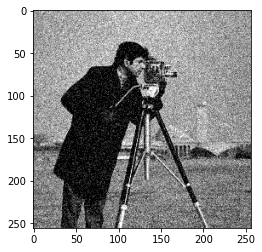

In [ ]:
Im_noised = add_gaussian_noise(Im_data, s=30)
plt.imshow(Im_noised, cmap='gray', **bounds)
plt.show()

In [ ]:
def scalar_product(u, v):
  return np.dot(u, v)

def norm(u):
  return np.linalg.norm(u, axis=0)

In [ ]:
def gradient(u):
  m, n = u.shape
  grad_u = np.zeros((2, m, n))
  
  grad_u[0, :-1, :] = u[1:] - u[:-1]
  
  grad_u[1, :, :-1] = u[:, 1:] - u[:, :-1]
  
  return grad_u

In [ ]:
def div(p):
  m, n = p.shape[1:]
  
  div_1 = np.zeros((m, n))
  div_1[:-1, :] = p[0, :-1, :]
  div_1[1:, :] -= p[0, :-1, :]
  
  div_2 = np.zeros((m, n))
  div_2[:, :-1] = p[1, :, :-1]
  div_2[:, 1:] -= p[1, :, :-1]
  
  return div_1 + div_2

In [ ]:
def laplacian(u):
  return div(gradient(u))

In [ ]:
def MSE(f, u):
  return ((f - u)**2).mean()
def PSNR(f, u):
  return 20 * np.log10(np.max(f)) - 10 * np.log10(MSE(f, u))

In [ ]:
def Denoise_Tikhinov(f, K, l, dt=None):
  if dt is None:
    dt = 1 / (l + 4)
  u = np.copy(f)
  for k in range(K):
    u += dt * (l * (f - u) + laplacian(u))
  return u

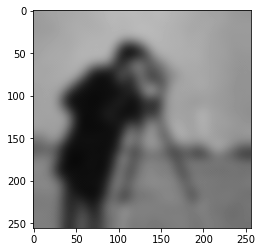

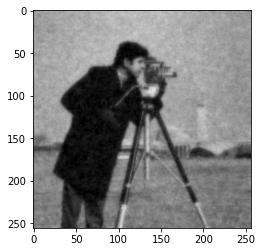

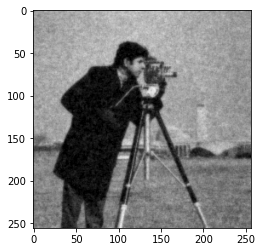

In [ ]:
Im_rec = Denoise_Tikhinov(Im_noised, 100, 0.0)
plt.imshow(Im_rec, cmap='gray', **bounds)
plt.show()

Im_rec = Denoise_Tikhinov(Im_noised, 100, 0.5)
plt.imshow(Im_rec, cmap='gray', **bounds)
plt.show()

Im_rec = Denoise_Tikhinov(Im_noised, 100, 1)
plt.imshow(Im_rec, cmap='gray', **bounds)
plt.show()

In [ ]:
def Denoise_TV(f, dt, K, l, eps):
  u = np.copy(f)
  for k in range(K):
    u += dt * (l * (f - u) + div(gradient(u) / np.sqrt(norm(gradient(u))**2 + eps)))
  return u

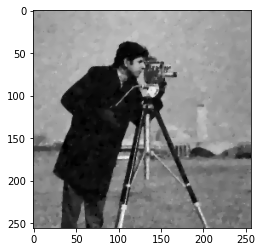

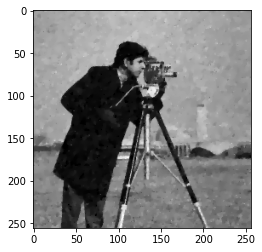

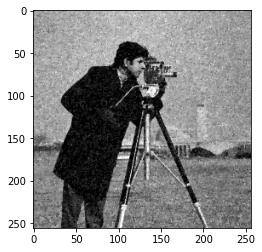

In [ ]:
Im_rec_TV = Denoise_TV(f=Im_noised, dt=1/8, K=200, l=0, eps=1)
plt.imshow(Im_rec_TV, cmap='gray', **bounds)
plt.show()

Im_rec_TV = Denoise_TV(f=Im_noised, dt=1/8, K=200, l=0.01, eps=1)
plt.imshow(Im_rec_TV, cmap='gray', **bounds)
plt.show()

Im_rec_TV = Denoise_TV(f=Im_noised, dt=1/8, K=200, l=0.1, eps=1)
plt.imshow(Im_rec_TV, cmap='gray', **bounds)
plt.show()

100%|██████████| 17/17 [04:07<00:00, 14.58s/it]


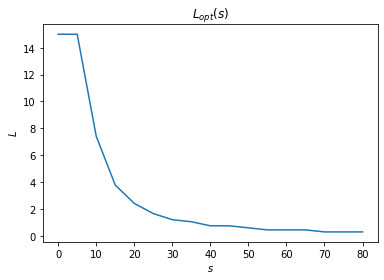

In [ ]:
s_range = list(range(0, 81, 5))
L_range = np.linspace(0, 15, 100)

L_opt = []
for s in tqdm(s_range):
  psnr = []
  noised = add_gaussian_noise(Im_data, s=s)
  for L in L_range:
    rec = Denoise_Tikhinov(noised, 100, L)
    psnr.append(PSNR(Im_data, rec))
  opt_idx = np.argmax(np.array(psnr))
  L_opt.append(L_range[opt_idx])

plt.plot(s_range, L_opt)
plt.title("$L_{opt}(s)$")
plt.xlabel("$s$")
plt.ylabel("$L$")
plt.show()

100%|██████████| 11/11 [00:18<00:00,  1.65s/it]


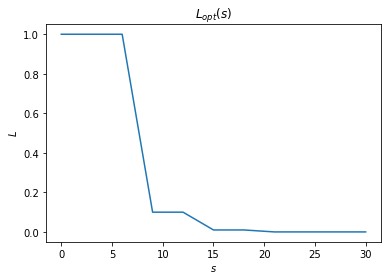

In [ ]:
s_range = list(range(0, 31, 3))
L_range = list(range(-4, 1))

L_opt = []
for s in tqdm(s_range):
  psnr = []
  noised = add_gaussian_noise(Im_data, s=s)
  for L in L_range:
    rec = Denoise_TV(f=noised, dt=1/8, K=100, l=10**L, eps=1)
    psnr.append(PSNR(Im_data, rec))
  opt_idx = np.argmax(np.array(psnr))
  L_opt.append(L_range[opt_idx])

plt.plot(s_range, [10**L for L in L_opt])
plt.title("$L_{opt}(s)$")
plt.xlabel("$s$")
plt.ylabel("$L$")
plt.show()

In [ ]:
from numpy.fft import fft2, ifft2

def Denoise_FT(f, l):
  m, n = f.shape
  p, q = np.meshgrid(range(1, m+1), range(1, n+1))
  F = fft2(f)
  U = l * F / (l + 4 * (np.sin(np.pi * p / m)**2 + np.sin(np.pi * q / n)**2))
  return np.abs(ifft2(U))

In [ ]:
for l in [0.01, 0.1, 1, 10]:
  Im_rec_FFT = Denoise_FT(f=Im_noised, l=l)
  # plt.imshow(Im_rec_FFT, cmap='gray', **bounds)
  # plt.show()

  Im_rec_Tikh = Denoise_Tikhinov(f=Im_noised, K=20, l=l)
  # plt.imshow(Im_rec_Tikh, cmap='gray', **bounds)
  # plt.show()

  print(f"l: {l}")
  print("FFT", PSNR(Im_data, Im_rec_FFT))
  print("Tikh", PSNR(Im_data, Im_rec_Tikh))

l: 0.01
FFT 16.853099943101434
Tikh 20.817611838172787
l: 0.1
FFT 20.713523652909238
Tikh 21.614436516743755
l: 1
FFT 24.277167237811636
Tikh 24.302238109326105
l: 10
FFT 21.358861918042532
Tikh 21.011991956097972


2. Extenions- Deconvolution and Inpainting

In [ ]:
def gaussian_kernel(dt, K):
  ssq = 2*K*dt
  P = np.floor(K * dt + 1)
  g = lambda x, y: 1/(2*np.pi*ssq) * np.exp(-1*((x-P+1)**2 + (y-P+1)**2)/(2*ssq))
  x, y = np.meshgrid(range(int(2*P-1)), range(int(2*P-1)))
  result = g(x, y)
  return result / np.sum(result)

In [ ]:
def convolve(G,f):
  return convolve2d(f,G, boundary='symm', mode='same')

In [ ]:
def Deconv_TV(f, G, dt, eps, K, l):
  u = np.copy(f)
  for k in range(K):
    u += dt * (convolve(l*G, (f - convolve(G,u))) + div(gradient(u) / np.sqrt(norm(gradient(u))**2 + eps**2)))
  return u

In [ ]:
def Inpainting_TV(f,M,dt,eps,K,l):
  u = np.copy(f)
  for k in range(K):
    u += dt * (l * (f - u) * M + div(gradient(u) / np.sqrt(norm(gradient(u))**2 + eps**2)))
  return u

In [ ]:
def Inpainting_Tikhonov(f,M,dt,K,l):
  u = np.copy(f)
  for k in range(K):
    u += dt * (l * (f - u) * M + laplacian(u))
  return u

In [ ]:
# using Im1
G = gaussian_kernel(1/8,20)
noised_img = add_gaussian_noise(convolve(G,Im_data), s=30)

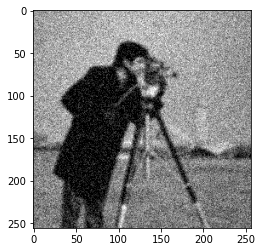

In [ ]:
plt.imshow(noised_img, cmap='gray', **bounds)
plt.show()

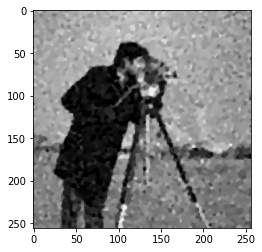

In [ ]:
Im_rec_deconv_TV = Deconv_TV(f=noised_img, G=G, dt=1/8, K=500, l=0.1, eps=1)
plt.imshow(Im_rec_deconv_TV, cmap='gray', **bounds)
plt.show()

100%|██████████| 6/6 [01:53<00:00, 18.86s/it]


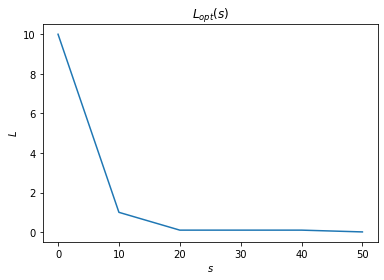

In [ ]:
s_range = list(range(0, 51, 10))
L_range = list(range(-2, 2))

L_opt = []
for s in tqdm(s_range):
  psnr = []
  noised_img = add_gaussian_noise(convolve(G,Im_data), s=s)
  for L in L_range:
    rec = Deconv_TV(f=noised_img, G=G, dt=1/8, K=500, l=10**L, eps=1)
    psnr.append(PSNR(Im_data, rec))
  opt_idx = np.argmax(np.array(psnr))
  L_opt.append(L_range[opt_idx])

plt.plot(s_range, [10**L for L in L_opt])
plt.title("$L_{opt}(s)$")
plt.xlabel("$s$")
plt.ylabel("$L$")
plt.show()

3it [04:26, 88.94s/it]


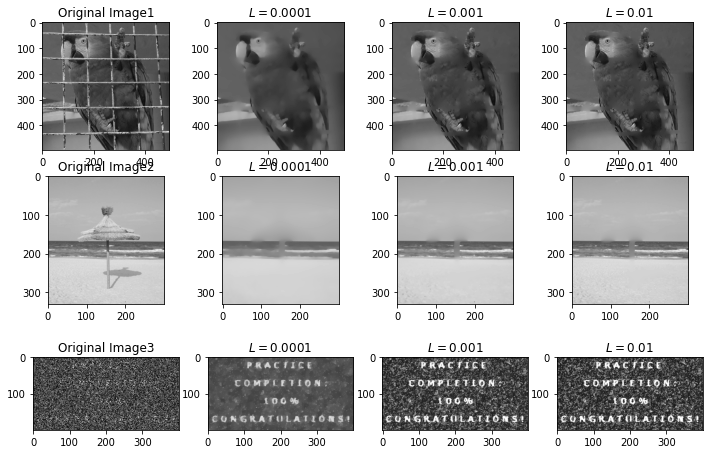

In [ ]:
L_range = list(range(-4, -1))
fig, axes = plt.subplots(nrows=3, ncols=len(L_range)+1, figsize=(12, 8))
axes[0, 0].set_title('Original Image1')
axes[0, 0].imshow(Im1, cmap='gray', **bounds)
axes[1, 0].set_title('Original Image2')
axes[1, 0].imshow(Im2, cmap='gray', **bounds)
axes[2, 0].set_title('Original Image3')
axes[2, 0].imshow(Im3, cmap='gray', **bounds)
for row, L in tqdm(enumerate(L_range)):
  img_inpaint1=Inpainting_TV(f=Im1,M=Im1_mask, dt=1/8, eps=1, K=10000, l=10**L)
  img_inpaint2=Inpainting_TV(f=Im2,M=Im2_mask, dt=1/8, eps=1, K=10000, l=10**L)
  img_inpaint3=Inpainting_TV(f=Im3,M=Im3_mask, dt=1/8, eps=1, K=10000, l=10**L)
  axes[0, row+1].set_title(f"$ L = {10**L}$")
  axes[0, row+1].imshow(img_inpaint1, cmap='gray', **bounds)
  axes[1, row+1].set_title(f"$ L = {10**L}$")
  axes[1, row+1].imshow(img_inpaint2, cmap='gray', **bounds)
  axes[2, row+1].set_title(f"$ L = {10**L}$")
  axes[2, row+1].imshow(img_inpaint3, cmap='gray', **bounds)

plt.show()

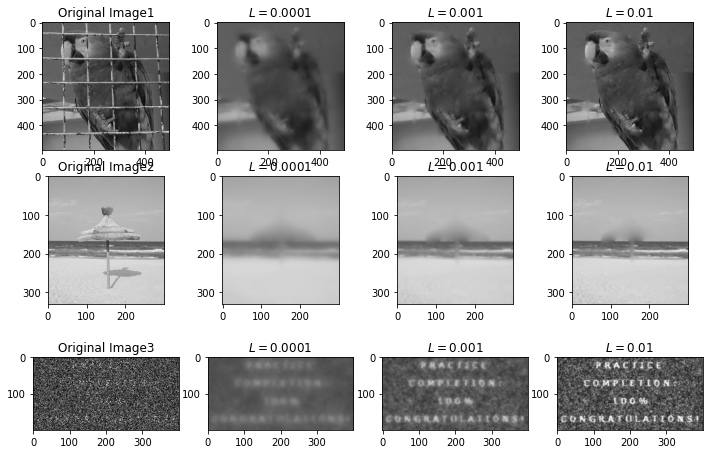

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 8))
L_range = list(range(-4, -1))
for row, L in enumerate(L_range):
  img_inpaint1=Inpainting_Tikhonov(f=Im1,M=Im1_mask, dt=1/8,K=10000,l=10**L)
  img_inpaint2=Inpainting_Tikhonov(f=Im2,M=Im2_mask, dt=1/8,K=10000,l=10**L)
  img_inpaint3=Inpainting_Tikhonov(f=Im3,M=Im3_mask, dt=1/8,K=10000,l=10**L)
  axes[0, 0].set_title('Original Image1')
  axes[0, 0].imshow(Im1, cmap='gray', **bounds)
  axes[1, 0].set_title('Original Image2')
  axes[1, 0].imshow(Im2, cmap='gray', **bounds)
  axes[2, 0].set_title('Original Image3')
  axes[2, 0].imshow(Im3, cmap='gray', **bounds)
  axes[0, row+1].set_title(f"$ L = {10**L}$")
  axes[0, row+1].imshow(img_inpaint1, cmap='gray', **bounds)
  axes[1, row+1].set_title(f"$ L = {10**L}$")
  axes[1, row+1].imshow(img_inpaint2, cmap='gray', **bounds)
  axes[2, row+1].set_title(f"$ L = {10**L}$")
  axes[2, row+1].imshow(img_inpaint3, cmap='gray', **bounds)

plt.show()

In [ ]:
def Denoise_g1(f, dt, K, l, eps):
  u = np.copy(f)
  for k in range(K):
    phi_p = lambda x: 2*x / (1 + x**2)**2
    u += dt * (l * (f - u) + div(phi_p(norm(gradient(u)))/(2*norm(gradient(u))) * gradient(u)))
  return u

In [ ]:
def Denoise_g2(f, dt, K, l, eps):
  u = np.copy(f)
  for k in range(K):
    phi_p = lambda x: 2*x / (1 + x**2)
    u += dt * (l * (f - u) + div(phi_p(norm(gradient(u)))/(2*norm(gradient(u))) * gradient(u)))
  return u

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


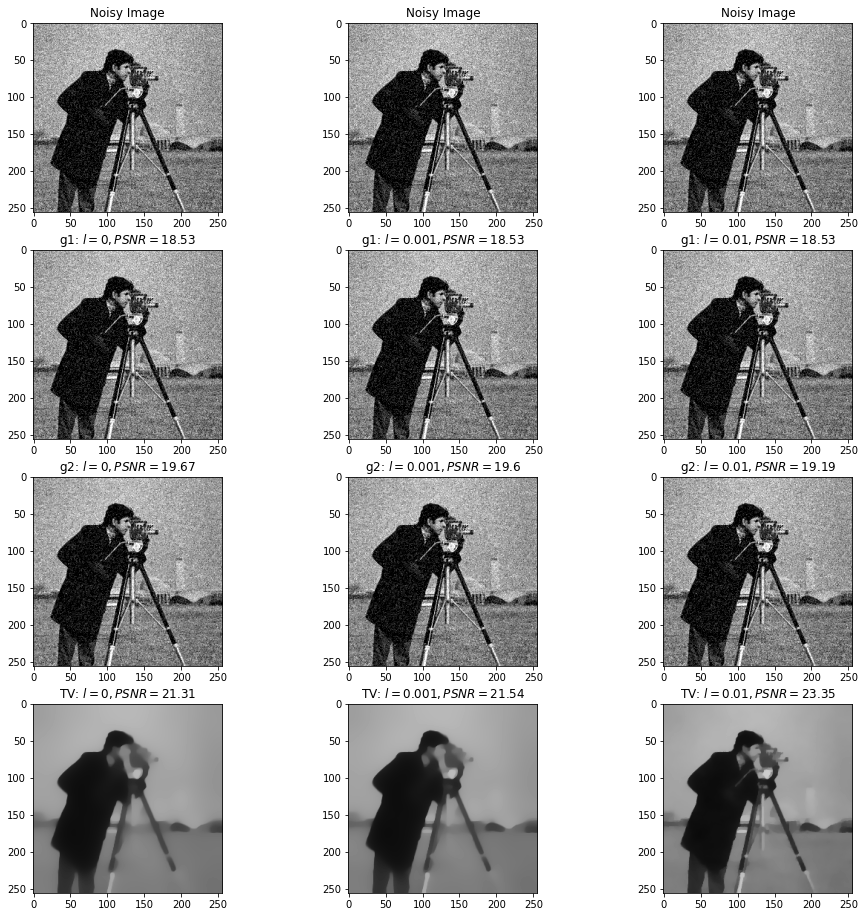

In [ ]:

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16,16))
L_range = [0, 0.001, 0.01]
for col, L in enumerate(L_range):
  axes[0, col].imshow(Im_noised, cmap='gray', **bounds)
  axes[0, col].set_title('Noisy Image')
  
  g1 = Denoise_g1(f=Im_noised, dt=1/4, K=500, l=L, eps=1)
  psnr_g1 = PSNR(Im_data, g1)
  axes[1, col].set_title(f"g1: $l = {L}, PSNR= {round(psnr_g1,2)}$")
  axes[1, col].imshow(g1, cmap='gray', **bounds)

  g2 = Denoise_g2(f=Im_noised, dt=1/4, K=500, l=L, eps=1)
  psnr_g2 = PSNR(Im_data, g2)
  axes[2, col].set_title(f"g2: $l = {L}, PSNR= {round(psnr_g2,2)}$")
  axes[2, col].imshow(g2, cmap='gray', **bounds)

  TV = Denoise_TV(f=Im_noised, dt=1/4, K=500, l=L, eps=1)
  psnr_TV = PSNR(Im_data, TV)
  axes[3, col].set_title(f"TV: $l = {L}, PSNR= {round(psnr_TV,2)}$")
  axes[3, col].imshow(TV, cmap='gray', **bounds)

plt.show()